<a id='top'></a>

# Lecture 2: How do computers add?

<div style="background-color: #ffe0b2; padding: 10px; border-left: 5px solid #ff9800;">
    <strong>Note:</strong> 
This lecture is based on Chapter 1 of [Fundamentals of Numerical Computation by Driscoll, Braun] which is avaliable <a href="https://fncbook.com/overview/">online</a> 
</div>

<div style="background-color: #ffe0b2; padding: 10px; border-left: 5px solid #ff9800;">
    <strong>Note:</strong> 
These notes contain some (but not all) of the content of the lecture. Please let me know if there are any additions that you feel are particularly important and let me know if you find any errors. 
</div>

Relative error of the phrase "2.2 pounds of jam is the same as a kilogram":

In [2]:
x = 2.20462262;
y = 2.2;

abs( x- y) / x

0.0020967851631676034

- Review of last week,
- [ChimeIn](https://chimein2.cla.umn.edu/chime/6801/folder/24220)
- Whiteboard I
  - Standard/scientific form  
  - general floating point numbers  
  - underflow, overflow, machine epsilon
  - Examples: half, single, double precision  
- Half precison = Float16 (<a href='#Float16'>Julia</a>)
- Whiteboard II  
  - round-off error, relative error in floating point representations and the distribution of floating-point numbers,
  - Conditioning 
  - Stability 

## Floating point numbers 

(standard/scientific form, Example: Planck's constant)

For fixed $\ell, k$, we define

\begin{align}
    \mathbb F_{k\ell} := 
    &\Bigg\{ 
        (-1)^s (1 + f) 2^n : f = (0.b_1b_2....b_k)_2, \quad n = c - (2^{\ell-1}-1), \quad c \in \{1,\dots,2^{\ell}-2\}\nonumber
    \Bigg\} \nonumber\\
    %
    &\cup \{\pm0, \pm\infty, \text{NaN}\} \cup \{ \text{subnormal numbers} \} \\ 
\end{align}

Here, 
* $k$ is the *binary precision*,
* $s\in \{0,1\}$ is the sign bit, so $(-1)^s$ is the *sign*,
* $1 + f$ is the *significand*,
* $f$ is the *matissa*, also called the *fraction*,
* $n$ is the *exponent*, belongs to $\{ 2 - 2^{\ell-1}, ...., 2^{\ell-1}-1 \}$,
* $c$ is the *characteristic*,
* $2^{\ell-1}-1$ is the *bias*

This is stored in a computer as the following $\ell + k + 1$ bits:

\begin{align} 
    \texttt{bitstring} \quad = \quad s \quad | \quad c \text{ written in binary} \quad | \quad  b_1b_2....b_k
\end{align} 

***Special values.*** 

When $c = 0$, $\texttt{bitstring}$ represents the number $(-1)^s f \cdot 2^{-(2^{\ell-1} - 1)}$. When $f = 0$, this encodes $\pm 0$ and when $f \not=0$ these are called *subnormal numbers*,

When $c = 2^{\ell}-1$, $\texttt{bitstring}$ represents $\pm \infty$ when $f = 0$ and $\text{NaN}$ when $f\not=0$.

<div class='alert alert-block alert-warning'><b>Example.</b> 

Write down all the floating point numbers with $k = 2$ in the interval $[1,2)$. What about the interval $[2,4)$? $[2^n,2^{n+1})$? 

There are $2^k$ equally spaced floating point numbers in any interval $[2^n,2^{n+1})$ (as long as $\ell$ is sufficiently large)

</div> 

*Maximum number* is $2^{2^{\ell-1} -1}( 2 - 2^{-k} ) \approx 2^{2^{\ell-1}}$. If the result of a computation exceeds this value, it is stored as $+\infty$ and we have an ***OVERFLOW*** error,

*Minimum positive (normal) number* is $2^{2-2^{\ell-1}}$. If the result of a computation is between this value and zero, it is stored as $0$ and we have an ***UNDERFLOW*** error,

*Machine precision* is $\epsilon_{\text{mach}} = 2^{-k}$ 

<div class='alert alert-block alert-warning'><b>Examples. </b>  </div> 

In the following, we will write $1|\ell|k$ for the number of bits used to represent the sign ($1$), the exponent ($\ell$), and the significand ($k$). 

In practice, we have:  
``Float16`` = half precision = $1|5|10$,   
``Float32`` = single precision = $1|8|23$, and   
``Float64`` = double precision = $1|11|52$,  

### Floating point arithmetic

We now consider double precision $\mathbb F := \mathbb F_{52,11}$ and define a function $\mathrm{fl} : \mathbb R \to \mathbb F$ that maps real numbers to (one of) the closest points in $\mathbb F$. 

Suppose that $x \in [2^n, 2^{n+1}]$ (and $\ell$ is sufficiently large). The floats in the interval $[2^n, 2^{n+1})$ are of the form 
$(1 + z \cdot 2^{-k}) \cdot 2^n$ for $z = 0,\dots,2^{k}-1$. Therefore, consectutive floats are spaced apart by $2^{n-k}$ and since $|x| \geq 2^n$, we have

\begin{align}
    \frac
        {| x - \mathrm{fl}(x) |}
        {|x|} 
    \leq \frac12
    \frac
        {2^{n-k}}
        {|x|} 
    \leq  \frac12 2^{-k} = \frac12 \epsilon_{\rm mach}
\end{align}

**Subtractive cancellation** when adding or subtracting numbers so that the result is much smaller in magnitude. For example, we know $x = -1.0000000000000000000147$ to $23$ significant digits but $x + 1 = 1.47 \times 10^{-22}$ to only $3$ significant digits.

This concept can be illustrated using (relative) condition number: suppose we are interested in a quantity $f(x)$ for $x\in \mathbb R$. In practice, we can only store $\widetilde{x} := \mathrm{fl}(x)$ in a computer (recall that $\widetilde{x} = x(1 + \epsilon)$ for some $|\epsilon|\leq \frac12 \epsilon_{\mathrm{mach}}$). Then the ratio of the relative error in the output to the relative error in the input in the limit as the precision goes to zero is known as the *(relative) condition number* $\kappa_f(x)$: 

\begin{align}
\frac
    {\left|\frac
        {f(x) - f(\widetilde{x})}
        {f(x)} \right|}
    {\left|\frac
        {x-\widetilde{x}}
        {x}\right|}
    %
    &= \left|
    \frac
        {f(x) - f(x + \epsilon x)}
        {\epsilon f(x)}
    \right| \nonumber\\
    %
    &\to \kappa_f(x) \quad \text{as } \epsilon \to 0
\end{align}

That is, the (relative) condition number is approximately the constant of pr0portionality between the relative error in the output and the relative error of the input:


\begin{align}
    \left|\frac
        {f(x) - f(\widetilde{x})}
        {f(x)} \right|
    \approx \kappa_f(x) \epsilon
\end{align}

<div class='alert alert-block alert-warning'><b>Example.</b> 

The condition number of $f(x) = x + 1$ is $\kappa_f(x) = \left|\frac{x}{x+1}\right|$. This blows up when $x\approx -1$ which explains subtractive cancellation that we mentioned above.

</div> 

If the condition number is large, we say the problem is *ill-conditioned* or the problem is badly conditioned


## ``Float16`` <a id='Float16'></a>

In Julia you can specify the precision by using ``FloatN()`` where $N = 16, 32,$ or $64$. e.g.

In [7]:
x = Float16( π );
x == 3.140625;

(1 + 1/2 + 1/16 + 1/128)*2

3.140625

You can see how this is represented in binary using ``bitstring()``:

In [5]:
bs = bitstring( x )

"0100001001001000"

Here, the first bit is the sign and the next 5 bits correspond to the characteristic:

In [8]:
s = parse(Int, bs[1:1], base=2);
c = parse(Int, bs[2:6], base=2);
@show ( s, c );

(s, c) = (0, 16)


The final bits ``bs[7:16]``$ := b_1b_2\cdots b_{10}$ represent the significand/mantissa in the following way 

$\begin{align}
f &= 0 . b_1 b_2 b_3 b_4 b_5 b_6 b_7 b_8 b_9 b_{10} \quad \text{in base }2 \\
%
&= \sum_{i=1}^{10} b_i 2^{-i}
\end{align}$

That is, ``bs[7:16]`` is $2^{10} \times$ larger than $f$:

In [9]:
f = 2^(-10) * parse(Int, bs[7:16], base=2)

0.5703125

In [67]:
# exponent is c - 15 (characteristic minus bias)
# significand is 1 + f
[ exponent(x), significand(x) ]

2-element Vector{Float16}:
 1.0
 1.57

In [68]:
y = (-1)^s * 2.0^( c - 15 ) * ( 1 + f )

3.140625

Recall that ``x = Float16( pi )``

In [69]:
x == y

true

Error in this representation: 

In [71]:
using Plots 
using LaTeXStrings 

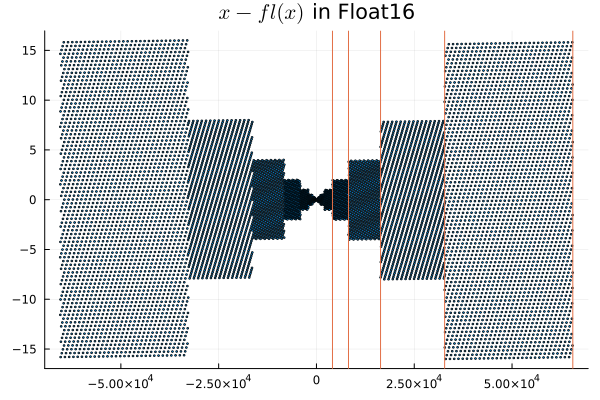

In [72]:
ϵ = eps( Float16 );
x = range( -2.0^(16), 2.0^(16), 10000 ); 
y = @. ( ( x - Float16(x) ) );

plot( x , y,  seriestype=:scatter, ms=1, title=L"$x - fl(x)$ in Float16", legend=false)
vline!( [2.0^n for n in 12:1:16] )

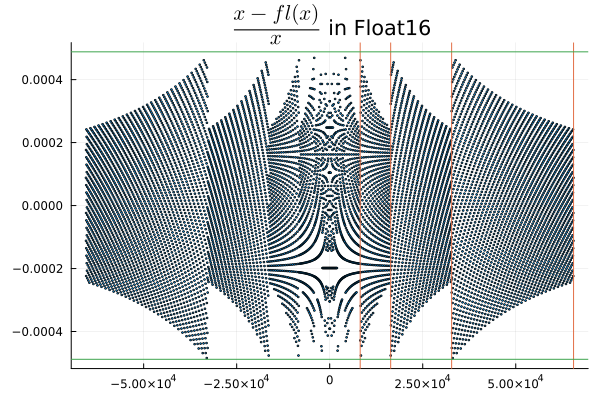

In [73]:
ϵ = eps( Float16 );
x = range( -2^(16), 2^(16), 10000 ); 
y = @. ( ( x - Float16(x) ) /x );

plot( x , y, seriestype=:scatter, ms=1, title=L"$\frac{x - fl(x)}{x}$ in Float16", legend=false)
vline!( [2.0^n for n in 13:1:16] )
hline!( [-ϵ/2, ϵ/2] )

Special values:

In [74]:
a = Float16( 0 );
(a, bitstring(a) )

(Float16(0.0), "0000000000000000")

In [82]:
b = -Float16( 0 );
(b, bitstring(b) )

(Float16(-0.0), "1000000000000000")

In [84]:
c = Float16( 1/0 );
(c, bitstring(c) )

(Inf16, "0111110000000000")

In [85]:
c = Float16( -1/0 );
(c, bitstring(c) )

(-Inf16, "1111110000000000")

In [87]:
c = Float16( 0/0 );
(c, bitstring(c) )

(NaN16, "1111111000000000")

By default, Julia uses ``Float64``. We will use this datatype for the remainder of this course.

In [12]:
typeof( 1.0 + π )

Float64

<a href='#top' style='float:right;'>⬆️</a>